In [1]:
import pandas as pd
import anndata as ad
import numpy  as np
import os
import sys
import dynamo as dyn
import scanpy as sc

In [2]:
# color
Color_key= {'HSC':"#D51F26",
            'MPP':"#89C75F",
            'LMPP':"#1E78B4",
            'MLP':"#EACEE3",
            'GMP':"#A1CDE1",
            'MEP':"#eebb44",
            'Prog_B 1':"#90D5E4",
            'Prog_B 2':"#208A42",
            'Naive B': "#8A9FD1",
            "Memory B":"#F47D2B",
            "Plasmablast":"#89288F",
            'Other':"grey"
           }

In [3]:
adata = sc.read("/media/liyaru/LYR/MM2023/5_Result/10_velocity/HD.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 3834 × 25051
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'cell', 'RNA_snn_res.0.5', 'seurat_clusters', 'predicted.celltype.score', 'predicted.celltype', 'integrated_snn_res.0.5', 'celltype', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous'
    var: 'highly_variable_genes', 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'


In [4]:
metadata= pd.read_csv("/media/liyaru/LYR/MM2023/5_Result/10_velocity/metadata.csv") # from seurat
metadata.columns[0]
metadata = metadata.rename(columns={'Unnamed: 0': 'cellname'})

obs = adata.obs
obs['cellname'] = obs.index
obs['cellname'] = obs['cellname'].str.replace('HD2','HD')
obs = obs.merge(metadata,on="cellname")
obs = obs.set_index("cellname")
adata.obs = obs

In [5]:
# dyn.pp.pca(adata)
dyn.pp.pca(adata,genes_to_append = ['SPI1'])

dyn.pp.recipe_monocle(adata,genes_to_append = ['SPI1'])
#adata[:, 'SPI1'].var['use_for_pca']  # check

dyn.tl.dynamics(adata, model='stochastic', cores=5)

dyn.tl.reduceDimension(adata)

dyn.tl.cell_velocities(adata, method='pearson', other_kernels_dict={'transform': 'sqrt'},basis='pca')


dyn.tl.cell_wise_confidence(adata)  

dyn.tl.confident_cell_velocities(adata, group='celltype', lineage_dict={'HSC': ['LMPP','Other'],
                                                                       'Prog_B 1': ['Naive B','Memory B'],
                                                                       'Naive B': ['Memory B'],
                                                                       'Memory B': ['Plasmablast']})


|-----> <insert> X_pca to obsm in AnnData Object.
|-----? dynamo.preprocessing.deprecated is deprecated.
|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> filtering cells...


/tmp/ipykernel_211344/3170263702.py:4: DeprecationWarning: recipe_monocle is deprecated and will be removed in a future release. Please update your code to use the new replacement function.
  dyn.pp.recipe_monocle(adata,genes_to_append = ['SPI1'])


|-----> 3834 cells passed basic filters.
|-----> filtering gene...
|-----> 7575 genes passed basic filters.
|-----> calculating size factor...
|-----> selecting genes in layer: X, sort method: SVR...
|-----> size factor normalizing the data, followed by log1p transformation.
|-----> Set <adata.X> to normalized data
|-----> applying PCA ...
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> cell cycle scoring...
|-----> computing cell phase...
|-----> [Cell Phase Estimation] completed [14.3981s]
|-----> [Cell Cycle Scores Estimation] completed [0.3719s]
|-----> [recipe_monocle preprocess] completed [4.3105s]
|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----------> removing existing M layers:[]...
|-----------> making adata smooth...
|-----> calculating first/second moments...
|-----> [moments calculation] completed [17.4880s]
|-----> retrieve data for non-linear dimension reduction...
|-----? adata 

calculating gene velocity vectors confidence based on phase portrait location with priors of progenitor/mature cell types: 2000it [01:06, 30.28it/s]
/home/liyaru/miniconda3/envs/Dynamo/lib/python3.8/site-packages/dynamo/tools/metric_velocity.py:436: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg = confidence.groupby("gene")["prog_confidence", "mature_confidence"].mean()


|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [1.8257s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [1.1486s]


AnnData object with n_obs × n_vars = 3834 × 25051
    obs: 'orig.ident_x', 'nCount_RNA_x', 'nFeature_RNA_x', 'percent.mt_x', 'cell_x', 'RNA_snn_res.0.5', 'seurat_clusters', 'predicted.celltype.score', 'predicted.celltype', 'integrated_snn_res.0.5', 'celltype', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'orig.ident_y', 'nCount_RNA_y', 'nFeature_RNA_y', 'percent.mt_y', 'sample', 'cell_y', 'celltype_new', 'CD34_celltype', 'Bcelltype', 'B_dupli_chr1', 'BC_Plasma', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase', 'jaccard_velocity_confidence'
    var: 'highly_variable_genes', 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'f

|-----------> plotting with basis key=X_umap
|-----------> skip filtering celltype_new by stack threshold when stacking color because it is not a numeric type


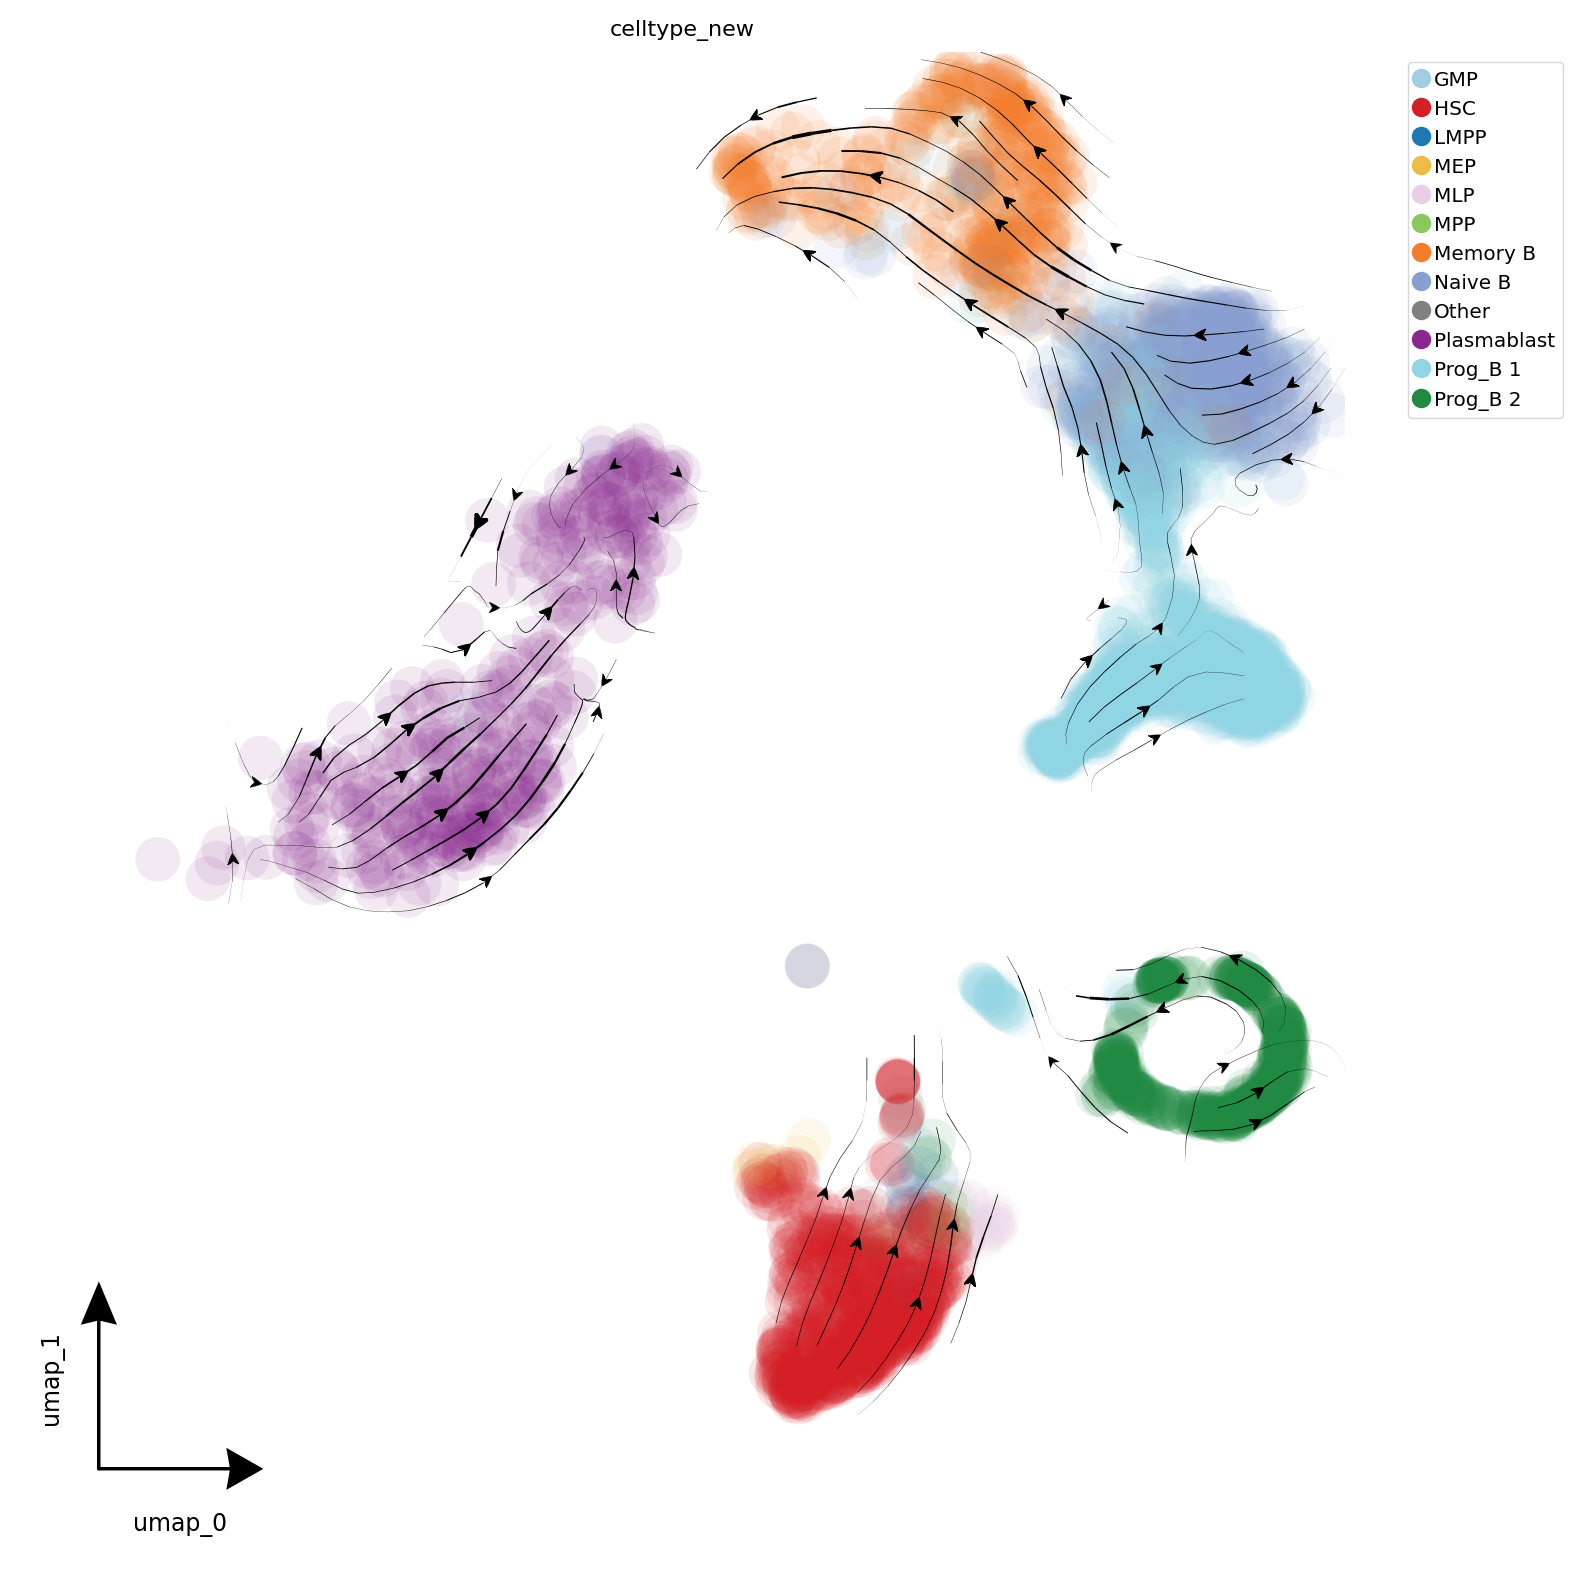

In [6]:
dyn.pl.streamline_plot(adata, 
                       color=['celltype_new'],
                       basis='umap',  
                       show_arrowed_spines=True,
                       show_legend='right',
                       color_key = Color_key,
                       figsize = [8,8])

In [7]:
# save figure
dyn.pl.streamline_plot(adata, color=['celltype_new'], basis='umap', 
                       #show_legend='on data', 
                       show_legend='right',
                       show_arrowed_spines=True,    
                       color_key = Color_key,
                       save_show_or_return = 'save',
                       save_kwargs =  {"path":"/media/liyaru/LYR/MM2023/6_PDF/Dynamo/HD", 
                                       "prefix":"Dynamo",
                                       "dpi":None,
                                       "ext":"svg"},
                       figsize = [8,8])


|-----------> plotting with basis key=X_umap
|-----------> skip filtering celltype_new by stack threshold when stacking color because it is not a numeric type
Saving figure to /media/liyaru/LYR/MM2023/6_PDF/Dynamo/Dynamo_HD.svg...
Done


In [8]:
dyn.vf.VectorField(adata, basis='pca')
dyn.vf.VectorField(adata, basis='umap')

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [4.5638s]
|-----> [VectorField] completed [4.7161s]
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [12.5042s]
|-----------> current cosine correlation between input velocities and learned velocities is less than 0.6. Make a 1-th vector field reconstruction trial.
|-----> [SparseVFC] begins...
|-----> Sampling con

In [9]:
# FCRL5 up
gene = "FCRL5"
dyn.pd.perturbation(adata, gene, [100], emb_basis="umap")
dyn.pl.streamline_plot(adata, color=["celltype_new"], basis="umap_perturbation", 
                       #show_legend='on data',  
                       show_legend='right',
                       show_arrowed_spines=True,    
                       color_key = Color_key,
                       save_show_or_return = 'save',
                       save_kwargs =  {"path":"/media/liyaru/LYR/MM2023/6_PDF/Dynamo/HD_FCRL5_overexpression", 
                                       "prefix":"Dynamo",
                                       "dpi":None,
                                       "ext":"svg"},
                       figsize = [8,8])

# FCRL5 down
gene = "FCRL5"
dyn.pd.perturbation(adata, gene, [-100], emb_basis="umap")
dyn.pl.streamline_plot(adata, color=["celltype_new"], basis="umap_perturbation", 
                       #show_legend='on data',  
                       show_legend='right',
                       show_arrowed_spines=True,    
                       color_key = Color_key,
                       save_show_or_return = 'save',
                       save_kwargs =  {"path":"/media/liyaru/LYR/MM2023/6_PDF/Dynamo/HD_FCRL5_knockdown", 
                                       "prefix":"Dynamo",
                                       "dpi":None,
                                       "ext":"svg"},
                       figsize = [8,8])


|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....


calculating Jacobian for each cell: 100%|██████████| 3834/3834 [00:00<00:00, 171021.30it/s]


|-----> project the pca perturbation vector to low dimensional space....
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [1.0504s]
|-----> you can use dyn.pl.streamline_plot(adata, basis='umap_perturbation') to visualize the perturbation vector
|-----------> plotting with basis key=X_umap_perturbation
|-----------> skip filtering celltype_new by stack threshold when stacking color because it is not a numeric type
Saving figure to /media/liyaru/LYR/MM2023/6_PDF/Dynamo/Dynamo_HD_FCRL5_overexpression.svg...
Done
|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....
|-----> project the pca perturbation vector to low dimensional space....
|-----> [projecting velocity vector to low dimensional embedding] in progress: 

In [10]:
# SPI1 up
gene = "SPI1"
dyn.pd.perturbation(adata, gene, [100], emb_basis="umap")
dyn.pl.streamline_plot(adata, color=["celltype_new"], basis="umap_perturbation", 
                       #show_legend='on data',  
                       show_legend='right',
                       show_arrowed_spines=True,    
                       color_key = Color_key,
                       save_show_or_return = 'save',
                       save_kwargs =  {"path":"/media/liyaru/LYR/MM2023/6_PDF/Dynamo/HD_SPI1_overexpression", 
                                       "prefix":"Dynamo",
                                       "dpi":None,
                                       "ext":"svg"},
                       figsize = [8,8])

# SPI1 down
gene = "SPI1"
dyn.pd.perturbation(adata, gene, [-100], emb_basis="umap")
dyn.pl.streamline_plot(adata, color=["celltype_new"], basis="umap_perturbation", 
                       #show_legend='on data',  
                       show_legend='right',
                       show_arrowed_spines=True,    
                       color_key = Color_key,
                       save_show_or_return = 'save',
                       save_kwargs =  {"path":"/media/liyaru/LYR/MM2023/6_PDF/Dynamo/HD_SPI1_knockdown", 
                                       "prefix":"Dynamo",
                                       "dpi":None,
                                       "ext":"svg"},
                       figsize = [8,8])

|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....


|-----> project the pca perturbation vector to low dimensional space....
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.9862s]
|-----> you can use dyn.pl.streamline_plot(adata, basis='umap_perturbation') to visualize the perturbation vector
|-----------> plotting with basis key=X_umap_perturbation
|-----------> skip filtering celltype_new by stack threshold when stacking color because it is not a numeric type
Saving figure to /media/liyaru/LYR/MM2023/6_PDF/Dynamo/Dynamo_HD_SPI1_overexpression.svg...
Done
|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....
|-----> project the pca perturbation vector to low dimensional space....
|-----> [projecting velocity vector to low dimensional embedding] in progress: 1

In [11]:
# CD24 up
gene = "CD24"
dyn.pd.perturbation(adata, gene, [100], emb_basis="umap")
dyn.pl.streamline_plot(adata, color=["celltype_new"], basis="umap_perturbation", 
                       #show_legend='on data',  
                       show_legend='right',
                       show_arrowed_spines=True,    
                       color_key = Color_key,
                       save_show_or_return = 'save',
                       save_kwargs =  {"path":"/media/liyaru/LYR/MM2023/6_PDF/Dynamo/HD_CD24_overexpression", 
                                       "prefix":"Dynamo",
                                       "dpi":None,
                                       "ext":"svg"},
                       figsize = [8,8])

# CD24 down
gene = "CD24"
dyn.pd.perturbation(adata, gene, [-100], emb_basis="umap")
dyn.pl.streamline_plot(adata, color=["celltype_new"], basis="umap_perturbation", 
                       #show_legend='on data',  
                       show_legend='right',
                       show_arrowed_spines=True,    
                       color_key = Color_key,
                       save_show_or_return = 'save',
                       save_kwargs =  {"path":"/media/liyaru/LYR/MM2023/6_PDF/Dynamo/HD_CD24_knockdown", 
                                       "prefix":"Dynamo",
                                       "dpi":None,
                                       "ext":"svg"},
                       figsize = [8,8])


|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....
|-----> project the pca perturbation vector to low dimensional space....
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.9131s]
|-----> you can use dyn.pl.streamline_plot(adata, basis='umap_perturbation') to visualize the perturbation vector
|-----------> plotting with basis key=X_umap_perturbation
|-----------> skip filtering celltype_new by stack threshold when stacking color because it is not a numeric type
Saving figure to /media/liyaru/LYR/MM2023/6_PDF/Dynamo/Dynamo_HD_CD24_overexpression.svg...
Done
|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculat

In [12]:
adata

AnnData object with n_obs × n_vars = 3834 × 25051
    obs: 'orig.ident_x', 'nCount_RNA_x', 'nFeature_RNA_x', 'percent.mt_x', 'cell_x', 'RNA_snn_res.0.5', 'seurat_clusters', 'predicted.celltype.score', 'predicted.celltype', 'integrated_snn_res.0.5', 'celltype', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'orig.ident_y', 'nCount_RNA_y', 'nFeature_RNA_y', 'percent.mt_y', 'sample', 'cell_y', 'celltype_new', 'CD34_celltype', 'Bcelltype', 'B_dupli_chr1', 'BC_Plasma', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase', 'jaccard_velocity_confidence', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'jacobian_det_pca'
    var: 'highly_variable_genes', 'vst.mean', 'vst.variance',

In [15]:
# save
adata.obs = adata.obs[['celltype_new','celltype']]
adata.uns['cell_phase_genes'] = None
adata.var.iloc[:,14:] = adata.var.iloc[:,14:].astype(str)

adata.write_h5ad("./HD_perturb.h5ad")

In [3]:
adata = sc.read_h5ad("./HD_perturb.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 3834 × 25051
    obs: 'celltype_new', 'celltype'
    var: 'highly_variable_genes', 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition', 'avg_prog_confidence', 'avg_mature_confidence', 'avg_confidence', 'confident_genes'
    uns: 'PCs', 'VecFld_pca', 'VecFld_umap', 'celltype_new_colors', 'dynamics', 'explained_variance_ratio_', 'feature_selection', 'gene_wise_confidence', 'grid_velocity_pca', 'grid_velocity_umap', 'grid_velocity_umap_perturbation', 'jacobian_pca', 'neighbors', 'pca_fit', 'pca_mean', 'pp', 'velocyto_SVR'
    obsm: 'X', 'X_pca', 'X_pca_SparseVFC', 'X_tsne', 'X_umap', 'X_umap_Spar

In [4]:
dyn.pl.cell_wise_vectors(adata, 
                         color=['celltype_new'], 
                         basis='umap', 
                       show_legend='right',
                       show_arrowed_spines=True,    
                       color_key = Color_key,
                       save_show_or_return = 'save',
                       save_kwargs =  {"path":"/media/liyaru/LYR/MM2023/6_PDF/Dynamo/HD_cell_new", 
                                       "prefix":"Dynamo",
                                       "dpi":None,
                                       "ext":"svg"},
                       quiver_size = 2,
                       quiver_length = 5,
                       pointsize = 0,
                       #frontier = True,
                       figsize = [8,8])

|-----> X shape: (3834, 2) V shape: (3834, 2)
|-----------> plotting with basis key=X_umap
|-----------> skip filtering celltype_new by stack threshold when stacking color because it is not a numeric type
Saving figure to /media/liyaru/LYR/MM2023/6_PDF/Dynamo/Dynamo_HD_cell_new.svg...
Done
